<a href="https://colab.research.google.com/github/cosmo3769/reinforcement_learning/blob/master/policy_gradient_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoLab Preambles

Most of the requirements of python packages are already fulfilled on CoLab. To run Gym, you have to install prerequisites like xvbf,opengl & other python-dev packages using the following codes.

In [1]:
%%capture
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y

For rendering environment, you can use pyvirtualdisplay. So fulfill that

In [2]:
%%capture
!pip install pyvirtualdisplay
!pip install pyglet

To activate virtual display we need to run a script once for training an agent, as follows:

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
# This code creates a virtual display to draw game images on.
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [5]:
"""
Utility functions to wrap_envenable video recording of gym environment and displaying it
To enable video, just do "env = (env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# Setup

In [6]:
import sys

import sklearn

import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Introduction to OpenAI gym

OpenAI gym is a great toolkit for training agents, developing and comparing Reinforcement Learning algorithms. It provides many simulated environments(Atari games, board games, 2D and 3D physical simulations) for your learning agents to interact with. Let's start by importing gym:

In [9]:
import gym
from gym import logger as gymlogger
# from gym.wrappers import Monitor
from gym.wrappers.record_video import RecordVideo # Monitor is deprecated
gymlogger.set_level(40) # error only
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's list all the available environments:
```
gym.envs.registry.all()
```

In [10]:
gym.envs.registry.all()

dict_values([EnvSpec(id='CartPole-v0', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='CartPole', version=0), EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='CartPole', version=1), EnvSpec(id='MountainCar-v0', entry_point='gym.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='MountainCar', version=0), EnvSpec(id='MountainCarContinuous-v0', entry_point='gym.envs.classic_control.co

Here, we’ve created a CartPole environment. This is a 2D simulation in which a cart can be accelerated left or right in order to balance a pole placed on top of it. The agent must move the cart left or right to keep the pole upright. Create an environment with make().

In [11]:
env = gym.make('CartPole-v1')

After the environment is created, you must initialize it using the reset() method. This returns the first observation:

In [12]:
env.seed(42)
obs = env.reset()

Observations depend on the type of environment. For the CartPole environment, each observation is a 1D NumPy array containing four floats: these floats represent the cart’s horizontal position (0.0 = center), its velocity (positive means right), the angle of the pole (0.0 = vertical), and its angular velocity (positive means clockwise).

In [13]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

Display this environment by calling its render() method:

In [14]:
env.render()

Here, we will set mode="rgb_array" to get an image of the environment as a NumPy array:

In [15]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [16]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

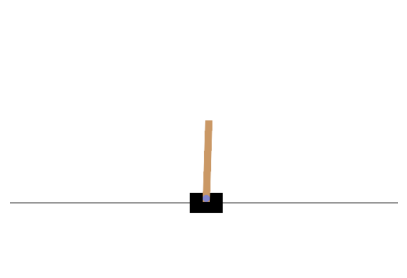

In [17]:
plot_environment(env)
plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [18]:
env.action_space

Discrete(2)

Discrete(2) means that the possible actions are integers 0 and 1, which represent accelerating left (0) or right (1).

Since the pole is leaning toward the right (obs[2] > 0), let's accelerate the cart toward the right:

In [19]:
action = 1  # accelerate right
obs, reward, done, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

The step() method executes the given action and returns four values.

Notice that the cart is now moving toward the right (obs[1] > 0). The pole is still tilted toward the right (obs[2] > 0), but its angular velocity is now negative (obs[3] < 0), so it will likely be tilted toward the left after the next step.

Saving figure cart_pole_plot


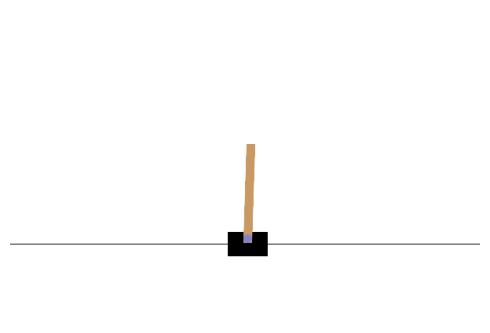

In [20]:
plot_environment(env)
save_fig("cart_pole_plot")

The four values returned by step() method is:

**obs** - This is the new observation. The cart is now moving toward the right (obs[1] > 0). The pole is still tilted toward the right (obs[2] > 0), but its angular velocity is now negative (obs[3] < 0), so it will likely be tilted toward the left after the next step.

**reward** - In this environment, you get a reward of 1.0 at every step, no matter what you do, so the goal is to keep the episode running as long as possible.

**done** - This value will be True when the episode is over. This will happen when the pole tilts too much, or goes off the screen, or after 200 steps (in this last case, you have won). After that, the environment must be reset before it can be used again.

**info** - This environment-specific dictionary can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

Once you have finished using an environment, you should call its
close() method to free resources.

In [21]:
reward

1.0

In [22]:
done

False

In [23]:
info

{}

The sequence of steps between the moment the environment is reset until it is done is called an "episode". At the end of an episode (i.e., when step() returns done=True), you should reset the environment before you continue to use it.

In [24]:
if done:
    obs = env.reset()

Now how can we make the poll remain upright? We will need to define a policy for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# Hard Coded Policy

Let’s hardcode a simple policy that accelerates left when the pole is leaning toward the left and accelerates right when the pole is leaning toward the right. We will run this policy to see the average rewards it gets over 500 episodes:

In [25]:
env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [26]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.212, 9.032998173364147, 24.0, 72.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 68 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode:

In [27]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

Now show the animation:

In [28]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [29]:
plot_animation(frames)

Even with 500 tries, this policy never managed to keep the pole upright for more than 68 consecutive steps. Not great. If you look at the simulation, you will see that the cart oscillates left and right more and more strongly until the pole tilts too much.

We have to come with a better policy, so here comes Neural Network Policies.

# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the action to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. In the case of the Cart-Pole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability p of the action 0 (left), and of course the probability of action 1 (right) will be 1 - p.

After the imports, we use a simple Sequential model to define the policy network. The number of inputs is the size of the observation space (which in the case of Cart‐Pole is 4), and we have just five hidden units because it’s a simple problem. Finally, we want to output a single probability (the probability of going left), so we have a single output neuron using the sigmoid activation function. If there were more than two possible actions, there would be one output neuron per action, and we would use the softmax activation function instead.

In [30]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

You may wonder why we plan to pick a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between exploring new actions and exploiting the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

Let's write a small function that will run the model to play one episode, and return the frames so we can display an animation:

In [31]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames


Now let's look at how well this randomly initialized policy network performs:

In [32]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 21ms/step


Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

We can make the same net play in 50 different environments in parallel (this will give us a diverse training batch at each step), and train for 5000 iterations. We also reset environments when they are done. We train the model using a custom training loop so we can easily use the predictions at each training step to advance the environments

In [33]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.079

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

Looks like it learned the policy correctly. Now let's see if it can learn a better policy on its own. One that does not wobble as much.

# Policy Gradients (PG) & Evaluating Actions: The Credit Assignment Problem

If we knew what the best action was at each step, we could train the neural network as usual, by minimizing the cross entropy between the estimated probability distribution and the target probability distribution. It would just be regular supervised learning. However, in Reinforcement Learning the only guidance the agent gets is through rewards, and rewards are typically sparse and delayed. For example, if the agent manages to balance the pole for 100 steps, how can it know which of the 100 actions it took were good, and which of them were bad? All it knows is that the pole fell after the last action, but surely this last action is not entirely responsible. This is called the **credit assignment problem**: when the agent gets a reward, it is hard for it to know which actions should get credited (or blamed) for it.

To tackle this problem, a common strategy is to **evaluate an action based on the sum of all the rewards that come after it, usually applying a discount factor γ (gamma) at each step**. This sum of discounted rewards is called the action’s **return**. If an agent decides to go right three times in a row and gets +10 reward after the first step, 0 after the second step, and finally –50 after the third step, then assuming we use a discount factor γ = 0.8, the first action will have a return of 10 + γ × 0 + γ2 × (–50) = –22. If the discount factor is close to 0, then future rewards won’t count for much compared to immediate rewards. Conversely, if the discount factor is close to 1, then rewards far into the future will count almost as much as immediate rewards. Typical discount factors vary from 0.9 to 0.99. With a discount factor of 0.95, rewards 13 steps into the future count roughly for half as much as immediate rewards (since 0.9513 ≈ 0.5), while with a discount factor of 0.99, rewards 69 steps into the future count for half as much as immediate rewards. In the
CartPole environment, actions have fairly short-term effects, so choosing a discount factor of 0.95 seems reasonable.

Of course, a good action may be followed by several bad actions that cause the pole to fall quickly, resulting in the good action getting a low return. However, if we play the game enough times, on average good actions will get a higher return than bad ones. We want to estimate how much better or worse an action is, compared to the other possible actions, on average. This is called the action **advantage**. For this, we must run many episodes and normalize all the action returns (by subtracting the mean and dividing by the standard
deviation). After that, we can reasonably assume that actions with a negative
advantage were bad while actions with a positive advantage were good. Perfect—now that we have a way to evaluate each action

The **Policy Gradients** algorithm tackles this **credit assignment problem** by first playing multiple episodes, then making the actions in good episodes slightly more likely, while actions in bad episodes are made slightly less likely. First we play, then we go back and think about what we did.

Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients (we will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be):

PG algorithms optimize the parameters of a policy by following the gradients toward higher rewards.

In [ ]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

If left_proba is high, then action will most likely be False (since a random number uniformally sampled between 0 and 1 will probably not be greater than left_proba). And False means 0 when you cast it to a number, so y_target would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

let's create another function that will rely on the **play_one_step()** function to play multiple episodes. This code returns a list of reward lists (one reward list per episode, containing one reward per step), as well as a list of gradient lists (one gradient list per episode, each containing one tuple of gradients per step and each tuple containing one gradient tensor per trainable variable).

In [ ]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

The Policy Gradients algorithm uses the **play_multiple_episodes()** function to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [ ]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [ ]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [ ]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

The first episode was much worse than the second, so its normalized advantages are all negative; all actions from the first episode would be considered bad, and conversely all actions from the second episode would be considered good

hyperparameters

In [ ]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [ ]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 190.2

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)